# Imports and constants

In [1]:
from dgm_utils import train_model, plot_training_curves

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ImageOps import invert

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchdiffeq import odeint_adjoint as odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset from image

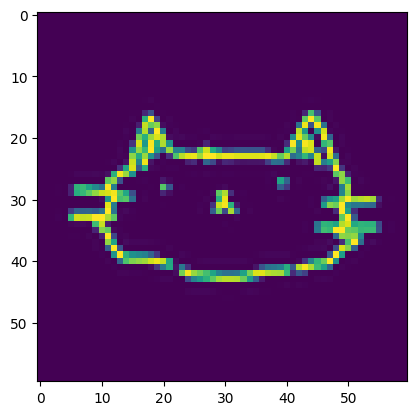

In [3]:
image = Image.open("cat2.png")
image = image.resize((60, 60), Image.ANTIALIAS)
image = invert(image)
image = np.array(image.convert('L'))
plt.imshow(image)

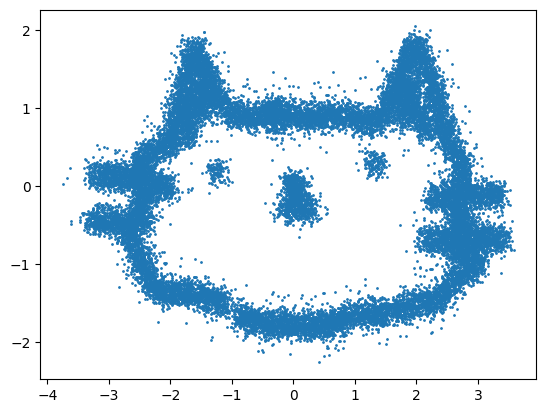

In [23]:
class ImageDataset(Dataset):
	"""Dataset from image"""

	def __init__(self, img, size=25000):
		self.probs = img.reshape(-1) / img.sum()

		h, w = img.shape
		xx, yy = np.meshgrid(np.linspace(-4, 4, w),
		       				 np.linspace(-4, 4, h))
		xx = xx.reshape(-1, 1)
		yy = yy.reshape(-1, 1)
		
		self.means = np.concatenate([xx, yy], 1)
		self.noise_std = np.array([4 / w, 4 / h])	

		self.points = self._sample(size)

	def __len__(self):
		return len(self.points)
	
	def __getitem__(self, idx):
		return self.points[idx]

	def _sample(self, n=1):
		# Generates indices of data points (samples from [0, ..., 784])
		indices = np.random.choice(self.probs.shape[0], n, p=self.probs)

		# Genrates data points of specified indices 
		m = self.means[indices]
		samples = np.random.randn(*m.shape) * self.noise_std + m
		return torch.from_numpy(samples).type(torch.FloatTensor)
	
##### TEST #####
dataset = ImageDataset(image)
plt.scatter(dataset[:, 0], -dataset[:, 1], s=1)

# Implementation of Continuous-in-time Normalizing Flows model

## Implementation of ODE function

In [5]:
class ODEfunc(nn.Module):

	def __init__(self, hidden=[64, 64]):
		super(ODEfunc, self).__init__()
		
		# Implementation of simple MLP
		features = [2] + hidden + [2]
		layers = [ ]
		for i, feature in enumerate(features[:-1]):
			layers.append(nn.Linear(feature + 1, features[i + 1]))
		self.net = nn.Sequential(*layers)


	def ode(self, t, z):
		"""Function that calculates dz/dt using simple MLP"""
		dz_dt = z
		t = t.expand(z.shape[0], 1)
		for layer in self.net[:-1]:
			# dz/dt depends on data and time
			z_time = torch.cat([dz_dt, t], dim=1)
			# Usign Softplus insead of Softmax because activation should be differentiable
			dz_dt = F.softplus(layer(z_time))

		# Last layer without activation
		z_time = torch.cat([dz_dt, t], dim=1)
		dz_dt = self.net[-1](z_time)
			
		return dz_dt


	def forward(self, t, states):
		z, _ = states

		with torch.set_grad_enabled(True):
			z.requires_grad_(True)
			
			# Computes first derivatives
			dz_dt = self.ode(t, z)

			# Computes trace of second derivatives
			trace = 0.0
			for i in range(z.shape[1]):
				trace += torch.autograd.grad(dz_dt[:, i].sum(), z, create_graph=True)[0][:, i]

		return dz_dt, -trace[:, None]
	

##### TEST #####
# test_ode = ODEfunc().to(device)
# test_ode(torch.tensor([0.0]).to(device), test_state)[0].shape


## Implementation of Continuous-in-time Normalizing Flows

In [24]:
class CNF(nn.Module):

	def __init__(self):
		super(CNF, self).__init__()
		self.dynamics = ODEfunc()
	
	def forward(self, z, reverse=False):
		dz_dt = torch.zeros(z.shape[0], 1).to(device)
		if reverse:
			integration_times = torch.tensor([0.0, 1.0]).to(device)
		else:
			integration_times = torch.tensor([1.0, 0.0]).to(device)

		# Integration
		state = odeint(
			self.dynamics, # Calculates time derivatives
			(z, dz_dt), # Initial values
			integration_times,
			atol=1e-5, # Error tolerance
			rtol=1e-5, # Error tolerance
		)
		# odeint outputs states for time t_0 and t_1, so return only at time t_1
		state = tuple(s[1] for s in state)
		return state
	
	def loss(self, x):
		# Solvels ODE using sample
		# z -- integral of ODE, i.e. sample that represents x in latent distribution
		# int_trace -- log p(x) - log p(z)
		z, int_trace = self(x)

		# Log likelihood of the base distribution samples
		logpz = self._norm_logprob(z)

		# Now to get loss substract log p(z) by integrated trace
		logpx = logpz - int_trace

		# CNF is solved by maximizing log p(x), so the equivalent problem is minimizing -log p(x)
		return {"total_loss": -torch.mean(logpx)} 
	
	def _norm_logprob(self, z):
		return (-np.log(2 * np.pi) - 0.5 * z**2).sum(1, keepdim=True)
	

##### TEST ######
test_cnf = CNF().cuda()
test_state = test_cnf(torch.zeros([10, 2]).cuda())
test_state[0].shape
	


torch.Size([10, 2])

  0%|          | 0/5 [00:00<?, ?it/s]

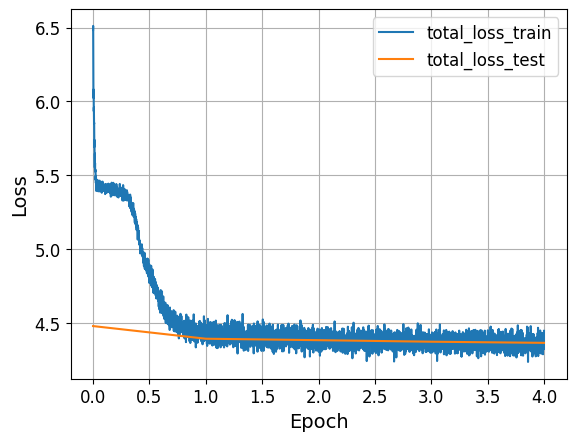

In [25]:
BATCH_SIZE = 512
SIZE = 1000 * BATCH_SIZE
EPOCHS = 5
LR = 1e-3

# Make a dataset to draw samples from an image-defined distribution.
train_data = ImageDataset(image, SIZE)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = ImageDataset(image, int(SIZE * 0.2))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Define the model.
model = CNF().to(device)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=True,
)

plot_training_curves(train_losses, test_losses)


# Samples

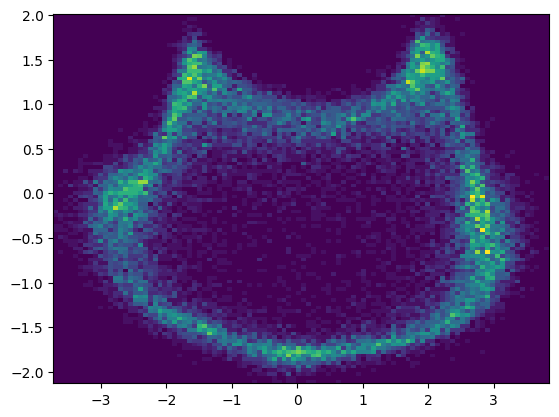

In [27]:
# Sample
z_samples = torch.randn(25000, 2).to(device)
samples, _ = model(z_samples, reverse=True)
samples = samples.cpu().detach().numpy()

# Plot samples
plt.hist2d(samples[:, 0], -samples[:, 1], bins=100)
plt.show()